In [1]:
import contextlib
import os
import sys
import time
import types
from typing import Optional, Tuple, Union

import pandas as pd
import torch
import torch.nn as nn
import transformers
import yaml
from torch import compile, optim
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from transformers import GPT2Config, GPT2LMHeadModel, GPT2Model, GPT2Tokenizer
from transformers.models.gpt2.modeling_gpt2 import GPT2Attention

import wandb

sys.path.append("..")

from models.gpt2 import GPT2Editor
from models.gpt2.config import GPT2EditorConfig
from train_utils import train, compute_kl_loss, slice_and_move_batch_for_device

%load_ext autoreload
%autoreload 2

In [2]:
stop_editing_index = 10  # 4090 or A6000j
edit_channel_multiply_factor = 2
num_editing_heads = 32  # more seems to be better for this #per sid's suggestion: can add more heads in every layer. This is probably a really great suggestion
editor_channel_width = 768 * edit_channel_multiply_factor
max_grad_clip = 4.0
chop_layer = 1
lr = 3e-4
edit_dampening_factor = 1e-4

In [3]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

Original implementation

In [4]:
def add_cross_attention_to_layer(block, config):
    block.crossattention = GPT2Attention(config, is_cross_attention=True)
    block.ln_cross_attn = nn.LayerNorm(
        normalized_shape=768, eps=config.layer_norm_epsilon
    )
    original_query_weights = block.attn.c_attn.weight[:, :768]
    original_keys_values = block.attn.c_attn.weight[:, 768:]
    original_query_bias = block.attn.c_attn.bias[:768]
    original_keys_values_bias = block.attn.c_attn.bias[768:]
    with torch.no_grad():
        # Initialize the new layer with these parameters
        block.crossattention.q_attn.weight = nn.Parameter(original_query_weights)
        block.crossattention.q_attn.bias = nn.Parameter(original_query_bias)
        block.crossattention.c_attn.weight = nn.Parameter(original_keys_values)
        block.crossattention.c_attn.bias = nn.Parameter(original_keys_values_bias)
    return


class Editor_Attention(nn.Module):
    def __init__(self, config):
        super().__init__()

        # Controls whether the head will do a global softmax in all positions & layers
        # If True, the attn is global and will sum to 1
        # If False, the attn is a logistic fxn independently for every layer & token
        # I suspect we will also want to penalize the intervention norm
        self.num_editing_heads = (
            config.num_editing_heads
        )  # should default to 1, but we're going to test adding more
        self.edit_channel_width = config.edit_channel_width
        if self.edit_channel_width % self.num_editing_heads != 0:
            print("Error: config hidden size is not divisible by num_editing_heads")
        self.head_dim = self.edit_channel_width // self.num_editing_heads
        self.embed_dim = config.hidden_size

        max_positions = (
            config.max_position_embeddings
        )  # does this do anything? can try killing this later
        self.register_buffer(
            "bias",
            torch.tril(
                torch.ones((max_positions, max_positions), dtype=torch.bool)
            ).view(1, 1, max_positions, max_positions),
            persistent=False,
        )
        self.register_buffer("masked_bias", torch.tensor(-1e4), persistent=False)

        # We compute Q and K as a single nn.linear; but will later break apart into subcomponents

        ## Before modification to a variable channel-width
        # self.q_attn = nn.Linear(self.embed_dim, self.embed_dim)
        # self.k_attn = nn.Linear(self.embed_dim, self.embed_dim)
        # self.v_attn = nn.Linear(self.embed_dim, self.embed_dim)
        # self.out_proj = nn.Linear(self.embed_dim, self.embed_dim)

        self.q_attn = nn.Linear(self.embed_dim, self.edit_channel_width)
        self.k_attn = nn.Linear(self.embed_dim, self.edit_channel_width)
        self.v_attn = nn.Linear(self.embed_dim, self.edit_channel_width)
        self.out_proj = nn.Linear(self.edit_channel_width, self.embed_dim)

    def _split_heads(self, x):
        """Split the last dimension into (num_heads, head_dim)."""
        new_shape = x.size()[:-1] + (self.num_editing_heads, self.head_dim)
        return x.view(*new_shape)

    def _new_reverse_attn(self, query, key, value, attention_mask=None, head_mask=None):
        # Assume that we are doing softmax attention
        # Project and split the query, key, value tensors
        split_query = self._split_heads(query)
        split_key = self._split_heads(key)
        split_value = self._split_heads(value)

        # Double-application (is this actually good/better for some reason?)
        # self._split_heads(self.q_attn(query))
        # self._split_heads(self.k_attn(key))
        # self._split_heads(self.v_attn(value))

        if split_query.dim() != 4:
            print("Error: Expected query to be 4D tensor, but got something else!")
        if split_key.dim() != 3:
            print("Error: Expected key to be 3D tensor, but got something else!")
        if split_value.dim() != 3:
            print("Error: Expected value to be 3D tensor, but got something else!")

        # Query should be shaped as (batch_index, sequence_index, head_index, head_dim)
        # Key and value should be shaped as (batch_index, head_index, head_dim)

        # print(
        #     "SHAPES PRIOR TO ATTN CALC",
        #     split_query.permute(0, 2, 1, 3).shape,
        #     split_key.unsqueeze(-1).shape,
        #     split_value.unsqueeze(-1).shape,
        # )

        # split_query: (bsz, seq, num_head, head_dim)
        # split_key:   (bsz, num_heads, head_dim, 1)

        # out: (bsz, num_heads, seq, 1) -> (bsz, num_heads, seq)

        KQ_weights = torch.matmul(
            split_query.permute(0, 2, 1, 3), split_key.unsqueeze(-1)
        ).squeeze(-1)

        # Scaling factor
        KQ_weights = KQ_weights / torch.full(
            [],
            split_value.size(-1) ** 0.5,
            dtype=KQ_weights.dtype,
            device=KQ_weights.device,
        )

        # Then we take the softmax within the positional divisions
        softmaxed_weights = nn.functional.softmax(KQ_weights, dim=-1)

        # Adjusting value selection for head dimension
        attn_output = torch.matmul(
            softmaxed_weights.unsqueeze(-1), split_value.unsqueeze(-2)
        )

        # combine heads: change 50, 8, 104, 96 to 50, 104, 768
        # first, permute
        attn_output = attn_output.permute(0, 2, 1, 3)

        # combin heads x head_dims
        attn_output = attn_output.reshape(
            -1, attn_output.size(1), attn_output.size(2) * attn_output.size(3)
        )
        # now project back
        projected_output = self.out_proj(attn_output)

        return projected_output, softmaxed_weights

    def _reverse_attn(self, query, key, value, attention_mask=None, head_mask=None):
        if key.dim() == 4:
            K_reduced = key[
                :, :, -1, :
            ]  # R# Check: that the second dimension of K is only a single element when we have batching
            KQ_weights = torch.bmm(K_reduced, query.transpose(1, 2))
            logistic_weights = torch.atan(KQ_weights)
            attn_output = torch.bmm(
                logistic_weights.transpose(1, 2),
                value[
                    :, :, -1, :
                ],  # we take the editor output only over the final token position
            )

        if key.dim() == 3:
            QK_weights = torch.matmul(query, key.transpose(-1, -2))
            logistic_weights = torch.atan(QK_weights)
            attn_output = torch.matmul(logistic_weights, value)

        return attn_output, logistic_weights

    def forward(
        self,
        editor_hidden_states,
        target_hidden_states,
        attention_mask=None,
        output_attentions=False,
    ):
        # Here, the query is the target hidden encoder, the key is the editor, and the value is the editor
        query = self.q_attn(target_hidden_states)
        if editor_hidden_states.dim() == 3:
            key = self.k_attn(
                # I don't quite understand why sometimes editor_hidden_states is 4 dimensional, sometimes 3
                # seems like it's sometimes 20, 1, 4, 768 and sometimes 20, 4, 768. what gives?
                editor_hidden_states[:, -1, :]
            )  # Pull only the final token position
            value = self.v_attn(
                # [:, 0, :1, :]
                editor_hidden_states[:, -1, :]
            )  # Pull only the final token position

        if editor_hidden_states.dim() == 4:
            key = self.k_attn(
                editor_hidden_states[:, 0, -1, :]
            )  # Pull only the final token position
            value = self.v_attn(
                # [:, 0, :1, :]
                editor_hidden_states[:, 0, -1, :]
            )  # Pull only the final token position

        attn_output, attn_weights = self._new_reverse_attn(query, key, value)

        if output_attentions:
            return attn_output, attn_weights
        else:
            return attn_output


def new_forward(
    self,
    input_ids: Optional[torch.LongTensor] = None,
    past_key_values: Optional[Tuple[Tuple[torch.Tensor]]] = None,
    attention_mask: Optional[torch.FloatTensor] = None,
    token_type_ids: Optional[torch.LongTensor] = None,
    position_ids: Optional[torch.LongTensor] = None,
    head_mask: Optional[torch.FloatTensor] = None,
    inputs_embeds: Optional[torch.FloatTensor] = None,
    encoder_hidden_states: Optional[torch.Tensor] = None,
    encoder_attention_mask: Optional[torch.FloatTensor] = None,
    # labels: Optional[torch.LongTensor] = None,
    use_cache: Optional[bool] = None,
    output_attentions: Optional[bool] = None,
    output_hidden_states: Optional[bool] = None,
    return_dict: Optional[bool] = None,
) -> Union[Tuple]:
    r"""
    labels (`torch.LongTensor` of shape `(batch_size, sequence_length)`, *optional*):
        Labels for language modeling. Note that the labels **are shifted** inside the model, i.e. you can set
        `labels = input_ids` Indices are selected in `[-100, 0, ..., config.vocab_size]` All labels set to `-100`
        are ignored (masked), the loss is only computed for labels in `[0, ..., config.vocab_size]`
    """

    transformer_outputs = self.transformer(
        input_ids,
        past_key_values=past_key_values,
        attention_mask=attention_mask,
        token_type_ids=token_type_ids,
        position_ids=position_ids,
        head_mask=head_mask,
        inputs_embeds=inputs_embeds,
        encoder_hidden_states=encoder_hidden_states,
        encoder_attention_mask=encoder_attention_mask,
        use_cache=use_cache,
        output_attentions=output_attentions,
        output_hidden_states=output_hidden_states,
        return_dict=return_dict,
    )

    # print(f"OLD {input_ids.shape=}, {attention_mask.shape=}")

    hidden_states = transformer_outputs[0]

    # print("HIDDEN STATE SHAPE", hidden_states.shape)

    # Set device for model parallelism
    if self.model_parallel and torch.cuda.is_available():
        torch.cuda.set_device(self.transformer.first_device)
        hidden_states = hidden_states.to(self.lm_head.weight.device)

    # lm_logits = self.lm_head(hidden_states)
    reverse_attention_output = self.lm_head(
        hidden_states, encoder_hidden_states, output_attentions=output_attentions
    )

    # print("REVERSE ATTENTION OUTPUT SHAPE", reverse_attention_output[0].shape)

    return reverse_attention_output


def replace_linear_final_layer_with_bespoke_reverse_attention(model):
    model.lm_head = Editor_Attention(config=model.config)
    model.forward = new_forward.__get__(model, GPT2LMHeadModel)
    return


@contextlib.contextmanager
def add_fwd_hooks(module_hooks):
    """
    Context manager for temporarily adding forward hooks to a model.

    Parameters
    ----------
    module_hooks
        A list of pairs: (module, fnc) The function will be registered as a
            forward hook on the module
    """
    try:
        handles = []
        for mod, hk in module_hooks:
            handles.append(mod.register_forward_hook(hk))
        yield
    finally:
        for h in handles:
            h.remove()


def assign_layer_indices(model):
    """
    Assigns a custom attribute 'layer_index' to each transformer layer in the GPT-2 model.
    This function iterates over the transformer blocks and assigns an index to each.
    """
    model.transformer.wte.layer_index = 0
    for i, layer in enumerate(model.transformer.h):
        layer.layer_index = i + 1


# Usage:
# assign_layer_indices(target_model)

In [5]:
# @torch.compile #Apparently this fails when used inside jupyter notebooks but is fine if i make dedicated scripts
class EditorHypernetwork(nn.Module):
    # Separating the editor config file, from its base model's configurations
    def __init__(
        self,
        num_editing_heads=32,
        edit_channel_width=768,  # controls dimensionality given to attention heads in the last layer of the editor
        use_layerwise_embeddings=True,
        chop_editor_at_layer=None,
        edit_dampening_factor=0.001,  # tuning parameter to help the edits not be initialized too large
        kill_token_zero=False,  # multiplies edits to token pos zero by zero
    ):
        super().__init__()

        # Construct Editor Model
        # Load the configuration from the YAML file
        # with open(editor_yaml_file_path, 'r') as file:
        #     self.config = yaml.safe_load(file)
        if torch.cuda.is_available():
            self.editor_model = (
                GPT2LMHeadModel.from_pretrained("gpt2").cuda().eval()
            )  # have recently added .cuda() so it uses the gpu
        else:
            self.editor_model = GPT2LMHeadModel.from_pretrained("gpt2").to("mps").eval()

        # Add cross-attention to each layer
        self.editor_model.config.add_cross_attention = True
        self.editor_model.config.num_editing_heads = num_editing_heads
        self.editor_model.config.chop_layer = chop_editor_at_layer
        self.editor_model.config.kill_token_zero = kill_token_zero
        self.editor_model.config.edit_channel_width = edit_channel_width

        if chop_editor_at_layer is None:
            chop_editor_at_layer = 12

        for i in range(chop_editor_at_layer):
            add_cross_attention_to_layer(
                self.editor_model.transformer.h[i], self.editor_model.config
            )

        # Delete extra layers beyond the chop_layer
        self.editor_model.transformer.h = self.editor_model.transformer.h[
            :chop_editor_at_layer
        ]

        # Replace the final linear layer with special reverse attention output
        self.editor_model.lm_head = Editor_Attention(config=self.editor_model.config)
        self.editor_model.forward = new_forward.__get__(
            self.editor_model, GPT2LMHeadModel
        )
        if torch.cuda.is_available():
            self.editor_model.cuda()
        else:
            self.editor_model.to("mps")

        # Construct Target Model
        if torch.cuda.is_available():
            self.target_model = (
                transformers.AutoModelForCausalLM.from_pretrained("gpt2").cuda().eval()
            )
        else:
            self.target_model = (
                transformers.AutoModelForCausalLM.from_pretrained("gpt2")
                .to("mps")
                .eval()
            )
        for param in self.target_model.parameters():
            param.requires_grad = False
        assign_layer_indices(self.target_model)

        if torch.cuda.is_available():
            self.target_model.cuda()
        else:
            self.target_model.to("mps")

        # Add module for layerwise embeddings
        if use_layerwise_embeddings:
            self.use_layerwise_embeddings = True
            self.layerwise_embeddings = torch.randn(13, 768, requires_grad=True).to(
                "cuda" if torch.cuda.is_available() else "mps"
            )
        else:
            self.use_layerwise_embeddings = False
            self.layerwise_embeddings = 0

        self.edit_dampening_factor = edit_dampening_factor

        self.residual_cache = None
        self.opt = None
        self.lossfn = None
        self.lam = None
        self.penalty_loss = None
        self.training_loss = None

    # Gets the hidden states from the target model, if necessary
    def run_target_model_for_encoded_hidden_states(self, target_ids):
        with torch.no_grad():
            outputs = self.target_model(target_ids, output_hidden_states=True)
            hidden_states = outputs.hidden_states
            return hidden_states

    def forward(
        self,
        editor_input_ids,
        target_input_ids,
        target_hidden_states=None,
        output_target_hidden_states=False,
        output_edited_hidden_states=False,
        output_edit_vectors=False,
        output_editor_attention=False,
        stop_editing_index=None,
        batch_edit_vectors=None,
    ):
        # Run target model for encoded hidden states
        if target_hidden_states is None:
            target_hidden_states = torch.stack(
                self.run_target_model_for_encoded_hidden_states(
                    target_input_ids.to("cuda" if torch.cuda.is_available() else "mps")
                ),  # seems to break while we are passing thru batch_size=1; the last (12th =) has different dimensions
                dim=2,
            )
        # dimensions of target_hidden_states:
        # batch_size, token_sequence_length, num_layers = 13, resid_width = 768

        # If we are stopping editing at stop_editing_index, then we eliminate target_hidden_states beyond that index
        if stop_editing_index is not None:
            target_hidden_states = target_hidden_states[
                :, :stop_editing_index, :, :
            ].clone()

        # Normalize along the last dimension
        normalization_factors = target_hidden_states.norm(dim=-1, keepdim=True)
        target_hidden_states = target_hidden_states / normalization_factors

        # Error catching:
        if batch_edit_vectors is not None:
            if output_edit_vectors or output_editor_attention:
                return "Error: Inputting your own batch_edit_vectors means the model does not construct the outputs you are requesting"

        # Run editor model, get edit vectors
        if batch_edit_vectors is None:
            if self.use_layerwise_embeddings:
                # Now, add in the layerwise embeddings
                embedded_hidden_states = (
                    target_hidden_states + self.layerwise_embeddings[None, None, :, :]
                )

                collapsed_target_hidden_states = embedded_hidden_states.reshape(
                    target_hidden_states.shape[0],
                    target_hidden_states.shape[1] * target_hidden_states.shape[2],
                    target_hidden_states.shape[3],
                )
            else:
                collapsed_target_hidden_states = target_hidden_states.reshape(
                    target_hidden_states.shape[0],
                    target_hidden_states.shape[1] * target_hidden_states.shape[2],
                    target_hidden_states.shape[3],
                )

            # print("EDITOR INPUT ID SHAPE", editor_input_ids.shape)
            # print("TARGET HIDDEN SHAPE", target_hidden_states.shape)

            editor_output = self.editor_model(
                editor_input_ids.to("cuda" if torch.cuda.is_available() else "mps"),
                encoder_hidden_states=collapsed_target_hidden_states,
                output_attentions=output_editor_attention,
            )
            # Multiply the outputs by normalization factors
            if output_editor_attention:
                temp_edit_vectors = editor_output[0]
                # Might want to reshape this too but whatever
                batch_editor_attention = editor_output[1]
            else:
                temp_edit_vectors = editor_output

            # print("TEMP EDIT VECTORS SHAPE", temp_edit_vectors.shape)

            # Renormalize to the scale of the target hidden states
            # and reshape to proper dimensions
            batch_edit_vectors = (
                self.edit_dampening_factor
                * normalization_factors
                * temp_edit_vectors.reshape(
                    temp_edit_vectors.shape[0], stop_editing_index, 13, 768
                )
            )

        # If we are stopping editing at stop_editing_index,
        # this pads batch_edit_vectors with 0's to the right of the edited positions
        if stop_editing_index is not None:
            batch_edit_vectors = torch.cat(
                (
                    batch_edit_vectors,
                    torch.zeros(
                        batch_edit_vectors.shape[0],
                        target_input_ids.shape[1] - stop_editing_index,
                        13,
                        768,
                    ).cuda(),
                ),
                dim=1,
            )

        # Run target model with edit vectors. This adds the edit vectors to the given hidden state at the specified batch index, position, and layer
        def edit_add(module, input, output):
            layer_index = module.layer_index
            output[0][:] = output[0] + batch_edit_vectors[:, :, layer_index, :]
            if self.editor_model.config.kill_token_zero == True:
                output[0][:, 0, :] = 0

        def embedding_edit_add(module, input, output):
            output[:] = output + batch_edit_vectors[:, :, 0, :]
            if self.editor_model.config.kill_token_zero == True:
                output[:, 0, :] = 0

        # Now editing the target model
        hooks1 = [(self.target_model.transformer.wte, embedding_edit_add)]
        hooks2 = [(self.target_model.transformer.h[L], edit_add) for L in range(12)]
        hooks = hooks1 + hooks2
        with add_fwd_hooks(hooks):
            # THIS IS THE LINE WHERE THE MODEL IS CALLED (AND THE EDITOR IS CALLED AT
            # THE END OF `layer` AS A SIDE EFFECT)
            target_result = self.target_model(
                target_input_ids.to("cuda" if torch.cuda.is_available() else "mps"),
                output_hidden_states=output_edited_hidden_states,
            )

        logits = target_result.logits

        output = {}
        output["logits"] = logits
        if output_target_hidden_states:
            output["target_hidden_states"] = (
                target_hidden_states * normalization_factors
            )
        if output_edited_hidden_states:
            output["edited_hidden_states"] = target_result.hidden_states
        if output_edit_vectors:
            output["edit_vectors"] = batch_edit_vectors
        if output_editor_attention:
            output["editor_attention"] = batch_editor_attention
        return output

    # Generate text using the target model, with a new edit application at every step.
    # This is a very slow way to generate text.
    # If you only want to edit first k tokens, use the forward pass instead with stop_editing_index = k
    def inspect_batch_prediction_ouptuts(self, batch):
        with torch.no_grad():
            batch_size = len(batch["tokenized_first_sentence"])
            self.editor_inputs = batch["tokenized_first_sentence"][i].unsqueeze(0)
            self.target_inputs = batch["tokenized_next_50_tokens"][i].unsqueeze(0)
            self.prediction = self.forward(
                self.editor_inputs,
                self.target_inputs,
                stop_editing_index=stop_editing_index,
                output_target_hidden_states=False,
                output_edited_hidden_states=False,
                output_edit_vectors=False,
                output_editor_attention=False,
            )
            # compute most likely tokens from the logits
            predicted_ids = [
                torch.argmax(pred, dim=-1) for pred in self.prediction["logits"]
            ]
            # convert the token ids to strings
            predicted_strings = [tokenizer.decode(pred) for pred in predicted_ids]
            return predicted_strings

    def evaluate_KL_test_loss_nogradient(
        self, dataloader, f_data_to_soft_labels=None, stop_editing_index=8
    ):
        with torch.no_grad():
            sum_weighted_losses = 0.0
            total_samples = 0
            for batch in dataloader:
                current_batch_size = len(batch["tokenized_first_sentence"])
                self.editor_inputs = batch["tokenized_first_sentence"].squeeze(1)
                self.target_inputs = batch["tokenized_next_50_tokens"].squeeze(1)
                self.prediction = self.forward(  # check the batch size
                    self.editor_inputs,
                    self.target_inputs,
                    stop_editing_index=stop_editing_index,
                )
                log_prob_predictions = torch.nn.functional.log_softmax(
                    self.prediction["logits"][:, stop_editing_index:, :].reshape(
                        -1, 50257
                    ),
                    dim=1,
                )
                # Now we must compute the soft labels!
                # join the last 50 tokens to the editor inputs
                soft_labels = f_data_to_soft_labels(
                    batch["tokenized_first_sentence"],
                    batch["tokenized_next_50_tokens"],
                    num_predictions_max=50,
                )
                mask = (batch["tokenized_next_50_tokens"] != 50256).reshape(-1)
                self.loss = torch.nn.functional.kl_div(
                    log_prob_predictions[mask, :],
                    soft_labels[mask, :],
                    reduction="batchmean",
                )
                # Weight the loss by current batch size and update the sum of weighted losses
                sum_weighted_losses += self.loss.item() * current_batch_size
                total_samples += current_batch_size
            weighted_average_loss = sum_weighted_losses / total_samples
        return weighted_average_loss

    def evaluate_crossentropy_test_loss_nogradient(
        self, dataloader, stop_editing_index=8
    ):
        with torch.no_grad():
            sum_weighted_losses = 0.0
            total_tokens = 0
            for batch in dataloader:
                # current_batch_size = len(batch["tokenized_first_sentence"])
                self.editor_inputs = batch["tokenized_first_sentence"].squeeze(1)
                self.target_inputs = batch["tokenized_next_50_tokens"].squeeze(1)
                self.prediction = self.forward(  # check the batch size
                    self.editor_inputs,
                    self.target_inputs,
                    stop_editing_index=stop_editing_index,
                )
                log_prob_predictions = torch.nn.functional.log_softmax(
                    self.prediction["logits"][:, stop_editing_index:, :].reshape(
                        -1, 50257
                    ),
                    dim=1,
                )

                # Create a mask to exclude padded tokens
                target_labels = self.target_inputs[:, stop_editing_index:].reshape(-1)
                mask = (
                    target_labels != 50256
                )  # Assuming padded tokens are represented by 0

                # Compute the cross-entropy loss with masking
                criterion = torch.nn.CrossEntropyLoss(reduction="none")
                loss = criterion(log_prob_predictions, target_labels)
                current_mask_sum = mask.sum()
                loss = (loss * mask).sum() / current_mask_sum

                # Weight the loss by current batch size and update the sum of weighted losses
                sum_weighted_losses += loss * current_mask_sum
                total_tokens += current_mask_sum
            weighted_average_loss = sum_weighted_losses / total_tokens
        return weighted_average_loss

    def run_train(
        self,
        train_loader,
        test_loader=None,
        stop_editing_index=8,
        epochs=1,
        KL_divergence_loss=False,
        lam=0,  # 20000
        lam_testing_penalty=0,  # 100000
        f_data_to_soft_labels=None,
        checkpoint_interval=60,  # save checkpoint every 60 minutes
    ):
        self.opt = optim.AdamW(
            self.parameters(), lr=lr, weight_decay=0.01
        )  # usually: lr = 5e-5. 1e-3 worked well!

        if KL_divergence_loss:
            self.lossfn = nn.KLDivLoss(reduction="batchmean")
        else:
            self.lossfn = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            # Create a tqdm progress bar
            with tqdm(
                total=len(train_loader),
                desc=f"Epoch {epoch + 1}/{epochs}",
                unit="batch",
                disable=True,
            ) as pbar:
                num_datapoints_in_epoch = 0
                epoch_train_loss = 0
                epoch_gradient_norm = 0
                # Train loop
                batch_index = -1  # index of first batch will be 0

                for step, batch in enumerate(
                    train_loader
                ):  # not sure what this does for fractional batches. meh whatev
                    batch_index += 1
                    self.batch = batch
                    current_batch_size = len(batch["tokenized_next_50_tokens"])
                    num_datapoints_in_epoch += current_batch_size
                    self.opt.zero_grad()

                    # Forward pass
                    self.prediction = self.forward(
                        batch["tokenized_first_sentence"],
                        batch["tokenized_next_50_tokens"],
                        stop_editing_index=stop_editing_index,
                        output_target_hidden_states=True,
                        output_edited_hidden_states=True,
                        output_edit_vectors=True,
                    )

                    # Compute the penalty (edit size relative to the hidden state)
                    self.lam = lam
                    edit_ratio = self.prediction["edit_vectors"].norm(dim=-1)[
                        :, :stop_editing_index, :
                    ] / self.prediction["target_hidden_states"].norm(dim=-1)
                    self.per_datapoint_penalty_loss = self.lam * torch.sum(
                        edit_ratio, dim=[1, 2]
                    )
                    self.penalty_loss = torch.mean(self.per_datapoint_penalty_loss)

                    # Compute the data loss
                    if KL_divergence_loss:
                        log_prob_predictions = torch.nn.functional.log_softmax(
                            self.prediction["logits"][:, :, :].reshape(-1, 50257),
                            dim=1,
                        )
                        # Now we must compute the soft labels! This is outsourced to the user-provided function, teacher_model
                        self.soft_labels = f_data_to_soft_labels(
                            batch["tokenized_first_sentence"],
                            batch["tokenized_next_50_tokens"],
                            num_predictions_max=50,
                        )
                        # check that the mask makes sense!
                        mask = (batch["tokenized_next_50_tokens"] != 50256).reshape(-1)
                        self.prediction_loss = self.lossfn(
                            log_prob_predictions[mask, :], self.soft_labels[mask, :]
                        )
                        # NOTE: currently I am letting the loss predict on tokens inside the editing window
                        # I didn't do this in the previous testing! Nor is it the case in crossentropy

                    else:
                        log_prob_predictions = torch.nn.functional.log_softmax(
                            self.prediction["logits"][
                                :, stop_editing_index:, :
                            ].reshape(-1, 50257),
                            dim=1,
                        )
                        # Create a mask to exclude padded tokens
                        # NOTE: here we are disallowing prediction on the first stop_editing_index tokens.
                        # Code is currently formatted such that this is not the case for KL
                        target_labels = batch["tokenized_next_50_tokens"][
                            :, stop_editing_index:
                        ].reshape(-1)
                        mask = target_labels != 50256
                        # Compute the cross-entropy loss with masking
                        criterion = torch.nn.CrossEntropyLoss(reduction="none")
                        loss = criterion(log_prob_predictions, target_labels.long())
                        current_mask_sum = mask.sum()
                        self.prediction_loss = (loss * mask).sum() / current_mask_sum

                    # Compute the total loss and backpropagate
                    self.training_loss = self.prediction_loss + self.penalty_loss
                    self.training_loss.backward()
                    nn.utils.clip_grad_norm_(
                        self.parameters(), max_grad_clip
                    )  # just implemented this! dunno if a cap of 1 to large, so I'm messing with reducing it

                    # Check for nan gradients
                    # if check_nan_gradients(self):
                    #     break

                    # Backwards step
                    self.opt.step()

                    # metrics
                    epoch_train_loss += self.training_loss.item() * current_batch_size
                    gradients = [
                        p.grad.view(-1) for p in self.parameters() if p.grad is not None
                    ]
                    all_gradients = torch.cat(gradients)
                    gradient_norm = torch.norm(all_gradients).item()
                    epoch_gradient_norm += gradient_norm * current_batch_size

                    metrics = {
                        "step": step * (epoch + 1),
                        "train_batch_total_loss": self.training_loss.item(),
                        "train_batch_prediction_loss": self.prediction_loss.item(),
                        "train_batch_penalty_loss": self.penalty_loss,
                        "train_batch_gradient_norm": gradient_norm,
                    }

                    if wandb.run:
                        wandb.log(metrics)
                    if step % 100 == 0:
                        print(metrics)

                    # Update progress bar
                    pbar.update(1)  # note: this was incorrectly displaying before!

                    # Check if it's time to save a checkpoint
                    current_time = time.time()
                    # first loop initialization
                    if batch_index == 0 and epoch == 0:
                        last_checkpoint_time = -100000

                    if current_time - last_checkpoint_time >= checkpoint_interval * 60:
                        # Save the checkpoint
                        torch.save(
                            self.state_dict(),
                            f"checkpoint_epoch_{epoch}_batch_{pbar.n}.pt",
                        )
                        last_checkpoint_time = current_time
                        # announce checkpoint save
                        print("Checkpoint saved at epoch", epoch, "batch", pbar.n)

                ####END BATCH LOOP
                #########################

                # epoch loss
                # epoch_test_prediction_loss = self.evaluate_crossentropy_test_loss_nogradient(
                #     test_loader,
                #     stop_editing_index,
                #     batch_size
                # )
                if KL_divergence_loss:
                    epoch_test_prediction_loss = self.evaluate_KL_test_loss_nogradient(
                        dataloader=test_loader,
                        f_data_to_soft_labels=f_data_to_soft_labels,
                        stop_editing_index=stop_editing_index,
                    )

                # # Calculate and accumulate gradient norm for logging
                # gradients = [p.grad.view(-1) for p in self.parameters() if p.grad is not None]
                # all_gradients = torch.cat(gradients)
                # gradient_norm = torch.norm(all_gradients).item()
                # epoch_gradient_norm += gradient_norm

                if wandb.run:
                    wandb.log(
                        {
                            "epoch_train_total_loss": epoch_train_loss
                            / num_datapoints_in_epoch,
                            "test_prediction_loss": epoch_test_prediction_loss,
                            "gradient_norm": epoch_gradient_norm
                            / num_datapoints_in_epoch,
                        }
                    )
            # Save the final model
            torch.save(self, "final_model.pt")

In [6]:
hypernetwork = EditorHypernetwork(
    edit_dampening_factor=edit_dampening_factor,  # 1/10000,
    use_layerwise_embeddings=False,
    num_editing_heads=num_editing_heads,
    edit_channel_width=editor_channel_width,
    chop_editor_at_layer=chop_layer,
)

In [7]:
new_model = GPT2Editor(
    GPT2EditorConfig(
        use_layerwise_embeddings=False,
        num_editing_heads=num_editing_heads,
        edit_channel_multiply_factor=edit_channel_multiply_factor,
        edit_dampening_factor=edit_dampening_factor,
        chop_editor_at_layer=chop_layer,
    )
).cuda()

In [8]:
from functools import partial


def disable_dropout(model: torch.nn.Module):
    """Disable dropout in a model."""
    for name, module in model.named_modules():
        print(f"disabling dropout for {name}")
        if isinstance(module, torch.nn.Dropout):
            module.p = 0


def constant_init(m, val=0.5):
    for p in m.parameters():
        nn.init.constant_(p.data, val)


disable_dropout(hypernetwork)
disable_dropout(new_model)

init_fn = partial(constant_init, val=0.1)

_ = hypernetwork.editor_model.apply(init_fn)
_ = new_model.hypernetwork.apply(init_fn)

disabling dropout for 
disabling dropout for editor_model
disabling dropout for editor_model.transformer
disabling dropout for editor_model.transformer.wte
disabling dropout for editor_model.transformer.wpe
disabling dropout for editor_model.transformer.drop
disabling dropout for editor_model.transformer.h
disabling dropout for editor_model.transformer.h.0
disabling dropout for editor_model.transformer.h.0.ln_1
disabling dropout for editor_model.transformer.h.0.attn
disabling dropout for editor_model.transformer.h.0.attn.c_attn
disabling dropout for editor_model.transformer.h.0.attn.c_proj
disabling dropout for editor_model.transformer.h.0.attn.attn_dropout
disabling dropout for editor_model.transformer.h.0.attn.resid_dropout
disabling dropout for editor_model.transformer.h.0.ln_2
disabling dropout for editor_model.transformer.h.0.mlp
disabling dropout for editor_model.transformer.h.0.mlp.c_fc
disabling dropout for editor_model.transformer.h.0.mlp.c_proj
disabling dropout for editor_mo

In [9]:
test_input_ids = torch.zeros(2, 8).long().cuda()
test_attention_mask = torch.ones_like(test_input_ids).cuda()
encoder_hidden_states = torch.ones(2, 8, 768).cuda()

with torch.no_grad():
    out_hn_old = hypernetwork.editor_model(
        input_ids=test_input_ids,
        attention_mask=test_attention_mask,
        encoder_hidden_states=encoder_hidden_states,
    )
    print("+" * 100)
    out_hn_new = new_model.hypernetwork(
        input_ids=test_input_ids,
        attention_mask=test_attention_mask,
        encoder_hidden_states=encoder_hidden_states,
    )

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


Next: let's test the models end-to-end

In [10]:
# Define example inputs for the models
inputs = {
    "input_ids": torch.tensor([[101, 2057, 2024, 100, 102, 1824, 1822, 1232, 121, 488]])
    .cuda()
    .repeat(2, 1),  # Example input_ids
    "attention_mask": torch.tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
    .repeat(2, 1)
    .cuda(),  # Example attention_mask
}

In [11]:
inputs["input_ids"] = torch.nn.functional.pad(
    inputs["input_ids"],
    (0, 32 - inputs["input_ids"].shape[-1]),
    value=tokenizer.pad_token_id,
)
inputs["attention_mask"] = torch.nn.functional.pad(
    inputs["attention_mask"], (0, 32 - inputs["attention_mask"].shape[-1]), value=0
)

In [12]:
# test_input_ids = torch.zeros(2, 8).long().cuda()
# test_attention_mask = torch.cat( torch.ones_like(test_input_ids).cuda()
# encoder_hidden_states = torch.ones(2, 8, 768).cuda()

new_model.config.use_ghost_token = False
stop_editing_index = 8

with torch.no_grad():
    out_hn_old = hypernetwork(
        editor_input_ids=inputs["input_ids"],
        target_input_ids=inputs["input_ids"],
        stop_editing_index=8,
    )
    print("+" * 100)
    out_hn_new = new_model.forward(
        editor_input_ids=inputs["input_ids"],
        editor_attention_mask=inputs["attention_mask"],
        target_input_ids=inputs["input_ids"],
        target_attention_mask=inputs["attention_mask"],
        stop_editing_idx=8,
    )

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


In [13]:
import datasets
from torch.utils.data import DataLoader

ds = datasets.load_from_disk(
    "/home/sidnbaskaran/hypernetwork-editor/assets/data/wikipedia-original"
)

max_length = 512
mode = "right"


def collate_fn(batch, max_length):
    res = {}
    for k in batch[0].keys():
        if k != "__index_level_0__":
            els = [x[k] for x in batch]
            if k == "tokenized_next_50_tokens":
                max_length = 50
                for i in range(len(els)):
                    els[i] = [j for j in els[i] if j != tokenizer.eos_token_id]
                    if len(els[i]) > 50:
                        els[i] = els[i][:50]
            # for x in els:
            #     x += [0] * (max_length - len(x))
            # res[k] = torch.cat([y , torch.zeros(max_length - len(x))],for y in els)
            # res[k]=torch.tensor([x + [0] * (max_length( - len(x)) for x in els], dtype=torch.long)

            res[k] = torch.stack(
                [
                    torch.nn.functional.pad(
                        torch.tensor(x),
                        (0, max_length - len(x))
                        if mode == "right"
                        else (max_length - len(x), 0),
                        value=tokenizer.eos_token_id,
                    )
                    for x in els
                ]
            ).int()
    return res


dl = DataLoader(
    ds["train"], batch_size=1, collate_fn=partial(collate_fn, max_length=max_length)
)

INFO:datasets:PyTorch version 2.3.0 available.


In [14]:
next(iter(dl))["tokenized_next_50_tokens"]

tensor([[ 3347,   373,   257,  2888,   286,   262,  3999,  2260,  1074,   326,
          1839,  3869,   379,  1111,   262, 14745,   376,  3824,    33,  6926,
           338,  2159,  5454,   290,   262, 14489,   376,  3824,    33,  6926,
           338,  2159, 10749,    13,  1375,   635,  1839,   257,  3869, 18279,
           379,   262, 14489,  7740,  5776,    11,   706,   543,   673,  9880]],
       dtype=torch.int32)

In [15]:
def concat_and_pad_left(first, second):
    batch_size, first_seq = first.size()
    pad_token = tokenizer.pad_token_id
    _, second_seq = second.size()
    # Find the lengths in A and B
    lengths_A = torch.sum(first != pad_token, dim=1)
    lengths_B = torch.sum(second != pad_token, dim=1)

    # initialize empty tensor
    max_len = max(lengths_A + lengths_B)
    result = torch.full(
        (
            batch_size,
            max_len,
        ),
        pad_token,
        device=first.device,
        dtype=first.dtype,
    )
    # Concatenate A[i] and B[i] a, assume LEFT padding
    for i in range(batch_size):
        result[i, max_len - lengths_B[i] - lengths_A[i] : max_len - lengths_B[i]] = (
            first[i, first_seq - lengths_A[i] :]
        )
        result[i, max_len - lengths_B[i] :] = second[i, second_seq - lengths_B[i] :]

    return result


def concat_and_pad_right(A, B):
    pad_token = tokenizer.pad_token_id
    batch_size, n_tokens_A = A.size()
    n_tokens_B = B.size(1)

    # Find the lengths in A and B
    lengths_A = torch.sum(A != pad_token, dim=1)
    lengths_B = torch.sum(B != pad_token, dim=1)

    # iniitalize empty tensor
    result = torch.full(
        (
            batch_size,
            max(lengths_A + lengths_B),
        ),
        pad_token,
        device=A.device,
    )

    # Concatenate A[i] and B[i] a
    for i in range(batch_size):
        result[i, : lengths_A[i]] = A[i, : lengths_A[i]]
        result[i, lengths_A[i] : lengths_A[i] + lengths_B[i]] = B[i, : lengths_B[i]]

    return result


concat_pad_fn = concat_and_pad_left if mode == "left" else concat_and_pad_right


def new_kl_loss(
    logits,
    target_model,
    batch,
):
    edited_target_logps = torch.nn.functional.log_softmax(logits, dim=-1)
    edit_target_mask = batch["tokenized_next_50_tokens"] != tokenizer.pad_token_id

    # compute soft labels
    with torch.no_grad():
        pad_token = target_model.config.eos_token_id
        combined_input_ids = concat_pad_fn(
            batch["tokenized_first_sentence"], batch["tokenized_next_50_tokens"]
        )

        target_logits = target_model(
            input_ids=combined_input_ids, attention_mask=combined_input_ids != pad_token
        ).logits

        lengths_A = torch.sum(batch["tokenized_first_sentence"] != pad_token, dim=1)
        lengths_B = torch.sum(batch["tokenized_next_50_tokens"] != pad_token, dim=1)

        # Create an empty tensor to store the predictions
        target_seq_len = edited_target_logps.shape[-2]
        shape = (
            len(lengths_A),
            target_seq_len,
            target_model.config.vocab_size,
        )
        extracted_logits = torch.full(
            shape, torch.nan, device=edited_target_logps.device
        )
        if mode == "left":
            # Extract the predictions corresponding to B, assume LEFT padding
            for i in range(len(lengths_A)):
                extracted_logits[i, -lengths_B[i] :, :] = target_logits[
                    i, -lengths_B[i] :, :
                ]
        elif mode == "right":
            # Extract the predictions corresponding to B
            for i in range(len(lengths_A)):
                extracted_logits[i, : lengths_B[i], :] = target_logits[
                    i, lengths_A[i] : lengths_A[i] + lengths_B[i], :
                ]
        target_logps = torch.nn.functional.log_softmax(extracted_logits, dim=-1)

    # compute KL div loss
    kl_div_loss = (
        target_logps[edit_target_mask, :].exp()
        * (target_logps[edit_target_mask, :] - edited_target_logps[edit_target_mask, :])
    ).sum(-1)

    return kl_div_loss.mean()


def old_kl_loss(logits, target, batch):
    log_prob_predictions = torch.nn.functional.log_softmax(
        logits[:, :, :].reshape(-1, 50257),
        dim=1,
    )

    def f_data_to_soft_labels(A, B, num_predictions_max=50):
        with torch.no_grad():
            # Compute number of nonzero elements in each row of A and B
            lengths_A = torch.sum(A != 50256, dim=1)
            lengths_B = torch.sum(B != 50256, dim=1)
            # Concatenate A and B along dimension 1
            data = concat_pad_fn(A, B)
            logits = target(data).logits
            predictions = torch.nn.functional.softmax(logits, dim=2)

            # Create an empty tensor to store the predictions
            shape = (len(lengths_A), num_predictions_max, 50257)
            hold_output = torch.full(shape, torch.nan, device=logits.device)

            if mode == "left":
                # Extract the predictions corresponding to B, assume LEFT padding
                for i in range(len(lengths_A)):
                    hold_output[i, -lengths_B[i] :, :] = predictions[
                        i, -lengths_B[i] :, :
                    ]
            elif mode == "right":
                # Extract the predictions corresponding to B
                for i in range(len(lengths_A)):
                    hold_output[i, : lengths_B[i], :] = predictions[
                        i, lengths_A[i] : lengths_A[i] + lengths_B[i], :
                    ]

            return hold_output.reshape(-1, 50257)  # returns

    # Now we must compute the soft labels! This is outsourced to the user-provided function, teacher_model
    soft_labels = f_data_to_soft_labels(
        batch["tokenized_first_sentence"],
        batch["tokenized_next_50_tokens"],
        num_predictions_max=50,
    )
    # check that the mask makes sense!
    mask = (batch["tokenized_next_50_tokens"] != 50256).reshape(-1)

    prediction_loss = torch.nn.functional.kl_div(
        log_prob_predictions[mask, :], soft_labels[mask, :], reduction="batchmean"
    )

    return prediction_loss

In [16]:
tokenizer.pad_token_id = tokenizer.eos_token_id

In [17]:
# test_input_ids = torch.zeros(2, 8).long().cuda()
# test_attention_mask = torch.cat( torch.ones_like(test_input_ids).cuda()
# encoder_hidden_states = torch.ones(2, 8, 768).cuda()

new_model.config.use_ghost_token = False
stop_editing_index = 8

batches, idx = 1000, 0


opt_new = optim.SGD(new_model.parameters(), lr=1e-3)
opt_old = optim.SGD(hypernetwork.parameters(), lr=1e-3)

losses_old = []
grads_old = []
losses_new = []
grads_new = []

for step, batch in enumerate(dl):
    idx += 1

    if idx > batches:
        break

    batch = {k: v.cuda() for k, v in batch.items()}

    # with torch.no_grad():
    out_hn_old = hypernetwork(
        editor_input_ids=batch["tokenized_first_sentence"],
        target_input_ids=batch["tokenized_next_50_tokens"],
        stop_editing_index=8,
    )

    out_hn_new = new_model.forward(
        editor_input_ids=batch["tokenized_first_sentence"],
        editor_attention_mask=(
            batch["tokenized_first_sentence"] != tokenizer.pad_token_id
        ).int(),
        target_input_ids=batch["tokenized_next_50_tokens"],
        target_attention_mask=(
            batch["tokenized_next_50_tokens"] != tokenizer.pad_token_id
        ).int(),
        stop_editing_idx=8,
    )

    # old_loss_old = old_kl_loss(
    #     out_hn_old["logits"],
    #     hypernetwork.target_model,
    #     batch,
    # ).item()
    # old_loss_new = old_kl_loss(
    #     out_hn_new.logits,
    #     hypernetwork.target_model,
    #     batch,
    # ).item()

    new_loss_old = new_kl_loss(
        out_hn_old["logits"],
        hypernetwork.target_model,
        batch,
    )
    new_loss_new = new_kl_loss(
        out_hn_new.logits,
        hypernetwork.target_model,
        batch,
    )

    opt_new.zero_grad()
    opt_old.zero_grad()

    new_loss_new.backward()
    new_loss_old.backward()

    opt_new.step()
    opt_old.step()

    # get gradients
    grads_new = [
        param.grad.detach().flatten()
        for param in new_model.parameters()
        if param.grad is not None
    ]
    norm_new = torch.cat(grads_new).norm()

    grads_old = [
        param.grad.detach().flatten()
        for param in hypernetwork.parameters()
        if param.grad is not None
    ]
    norm_old = torch.cat(grads_old).norm()

    # print(f"{norm_new.item()=}, {norm_old.item()=}")
    print(f"{step=}: {new_loss_new.item()=} {new_loss_old.item()=}")

    losses_old.append(new_loss_old.item())
    losses_new.append(new_loss_new.item())
    grads_old.append(norm_old.item())
    grads_new.append(norm_new.item())

step=0: new_loss_new.item()=0.2964380979537964 new_loss_old.item()=0.29643791913986206
step=1: new_loss_new.item()=0.5079061985015869 new_loss_old.item()=0.5079073905944824
step=2: new_loss_new.item()=0.627036988735199 new_loss_old.item()=0.6270367503166199
step=3: new_loss_new.item()=0.45889222621917725 new_loss_old.item()=0.4588923454284668
step=4: new_loss_new.item()=0.5651694536209106 new_loss_old.item()=0.5651690363883972
step=5: new_loss_new.item()=0.33995258808135986 new_loss_old.item()=0.3399530053138733
step=6: new_loss_new.item()=0.6096089482307434 new_loss_old.item()=0.6096099615097046
step=7: new_loss_new.item()=0.40355342626571655 new_loss_old.item()=0.4035540223121643
step=8: new_loss_new.item()=1.3793654441833496 new_loss_old.item()=1.3793659210205078
step=9: new_loss_new.item()=0.2196909338235855 new_loss_old.item()=0.21969106793403625
step=10: new_loss_new.item()=0.45907294750213623 new_loss_old.item()=0.4590739905834198
step=11: new_loss_new.item()=0.3992139399051666 

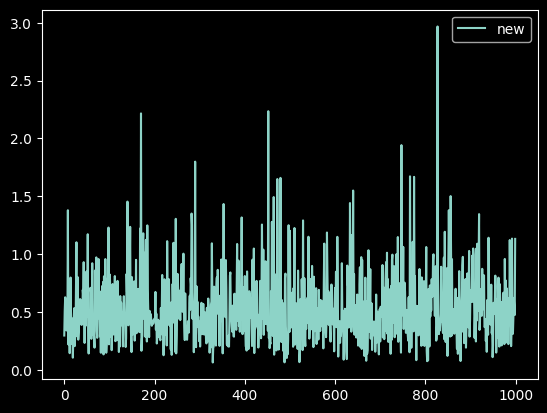

In [18]:
from matplotlib import pyplot as plt

plt.plot(losses_new, label="new")

plt.legend()

plt.show()

In [19]:
position_ids = torch.arange(0, 8).unsqueeze(0).cuda()
input_ids = torch.zeros(1, 5).long().cuda()

right_padded = torch.nn.functional.pad(input_ids, (0, 3), mode="constant", value=50256)
rp_pos = (right_padded != 50256).cumsum(-1)
attn_mask_rp = (right_padded != 50256).int()

left_padded = torch.nn.functional.pad(input_ids, (3, 0), mode="constant", value=50256)
lp_pos = (left_padded != 50256).cumsum(-1)
attn_mask_lp = (left_padded != 50256).int()

lpout = hypernetwork.target_model(
    input_ids=left_padded, attention_mask=attn_mask_lp, position_ids=lp_pos
)
rpout = hypernetwork.target_model(
    input_ids=right_padded, attention_mask=attn_mask_rp, position_ids=rp_pos
)

In [20]:
attn_mask_lp, attn_mask_rp

(tensor([[0, 0, 0, 1, 1, 1, 1, 1]], device='cuda:0', dtype=torch.int32),
 tensor([[1, 1, 1, 1, 1, 0, 0, 0]], device='cuda:0', dtype=torch.int32))

In [21]:
lp_pos, rp_pos

(tensor([[0, 0, 0, 1, 2, 3, 4, 5]], device='cuda:0'),
 tensor([[1, 2, 3, 4, 5, 5, 5, 5]], device='cuda:0'))

In [22]:
torch.allclose(lpout.logits, rpout.logits)

False